<a href="https://colab.research.google.com/github/google/ground-platform/blob/master/notebooks/generate_offline_imagery2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Post-process Ground imagery (2/2)

This notebook converts normal GeoTIFFs into cloud optimized-GeoTIFFs (COGs) compatible with Google Maps Platform APIs and the Ground data collection platform Android app.

We've affectionally dubbed these Maps-optimized COGs as "MOGs" for convenience and brevity. See [README.md](https://github.com/google/ground-android/blob/master/ground/src/main/java/com/google/android/ground/ui/map/gms/mog/README.md) in Android implementation for details.

Be sure [Generate Ground offline imagery](https://colab.research.google.com/github/google/ground-platform/blob/master/notebooks/generate_offline_imagery1.ipynb) has been run and Earth Engine tasks have completed before running this notebook.

By default, only new input images will be converted. GeoTIFF which already have a correspondign MOG will be skipped unless `OVERWRITE_EXISTING` is set `True`.

##  Configuration

### Required inputs

In [ ]:
BUCKET_NAME=input('ID of bucket where GeoTIFFs are read and written: ')

### Custom paths

The can be adjusted as needed.

In [ ]:
SRC_PATH="2022/geotiff"
DEST_PATH="2022/cog"

### Other constants

Only modify these if you know what you're doing!

In [ ]:
HI_RES_MOG_MIN_ZOOM=8
HI_RES_MOG_MAX_ZOOM=14
SRC_PREFIX=f"{SRC_PATH}/{HI_RES_MOG_MIN_ZOOM}"
WORLD_PATH=f"{SRC_PREFIX}/world.tif"
WORLD_MASKED_PATH=f"{SRC_PREFIX}/world-masked.tif"
DEST_PREFIX=f"{DEST_PATH}/{HI_RES_MOG_MIN_ZOOM}"
OVERWRITE_EXISTING=False

# Constants
TMP_FILENAME="temp.tif"
GCS_BROWSER_BASE_URL="https://console.cloud.google.com/storage/browser"
GCS_DETAILS_BASE_URL="https://console.cloud.google.com/storage/browser/_details"

## Setup

### Authenticate user

In [ ]:
from google.colab import auth

auth.authenticate_user()

### Install deps

In [ ]:
!pip install rasterio rio-cogeo gdal

### Imports and vars

In [ ]:
from google.cloud import storage
import rasterio
from osgeo import gdal # https://gdal.org/api/python/osgeo.gdal.html
import os
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import re
from google.cloud import storage

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)

## Generate masked world COG

Applies a NODATA mask to the global overview COG to include only areas with hi-res imagery. This provides users of the Ground Android app with a consistent user experience across zoom levels; it ensures the same extents are shown at both higher and lower zoom levels.

### Build image locally

In [ ]:
def trim_affixes(name):
  return name[len(SRC_PREFIX)+1:len(name)-4]

def name_to_coord(name):
  return [int(x) for x in name.split('/')]

def get_mask_coords():
  src_blobs = storage_client.list_blobs(BUCKET_NAME, prefix=SRC_PREFIX)
  xy_strs = [trim_affixes(b.name) for b in src_blobs if b.name.endswith(".tif")]
  tile_coords = [name_to_coord(xy) for xy in xy_strs if re.match(r'\d+/\d+', xy)]
  # Assumes world.tif covers up to one zoom level less than detailed COGs
  # Coord (256 * X/2, 256 * Y/2)
  return [(xy[0]*128, xy[1]*128) for xy in tile_coords]

def show_thumbnail(src_path):
  with rasterio.open(src_path) as src:
    max_factor=64
    plt.figure(figsize=(2, 2))
    show(src.read(out_shape=(3, int(src.height / max_factor), int(src.width / max_factor))))

src_path = f"/vsigs_streaming/{BUCKET_NAME}/{WORLD_PATH}"

mask_coords = get_mask_coords()

os.remove(TMP_FILENAME) if os.path.exists(TMP_FILENAME) else None
# Create masked TIFF.
with rasterio.open(src_path) as src:
  nbands = src.count
  # Build mask.
  mask = np.zeros((nbands, src.height, src.width), dtype=np.uint8)
  for (x, y) in mask_coords:
    # Python array indices are right-exclusive (this will include 0..127).
    mask[:nbands, y:y+128, x:x+128] = 1
  with rasterio.open(TMP_FILENAME,
                     mode='w',
                     **src.meta,
                     compress=src.compression,
                     tiled=True,
                     blockxsize=256,
                     blockysize=256) as dest:
    # Read all the data.
    data = src.read()
    # Replace actual zero values with neighboring value.
    data[data == 0] = 1
    # Apply nodata mask.
    dest.nodata = 0
    data = np.multiply(data, mask)
    # Write the data back to the geotiff file
    dest.write(data)
    dest.close()

print("World overview image:")
show_thumbnail(TMP_FILENAME)


### Upload to GCS

In [ ]:
# Upload resulting masked TIFF to GCS.
bucket.blob(WORLD_MASKED_PATH).upload_from_filename(TMP_FILENAME)

## Build MOGs


### Define functions

In [ ]:
def show_thumbnail(src_path):
  with rasterio.open(src_path) as src:
    max_factor=src.overviews(1)[-1]
    plt.figure(figsize=(1, 1))
    show(src.read(out_shape=(3, int(src.height / max_factor), int(src.width / max_factor))))

def convert_file(src_path, dst_path):
  """Convert image to Maps Optimized GeoTIFF."""

  gdal.UseExceptions()

  # Open the input raster
  src=gdal.Open(src_path)

  # Open the output raster
  ds=gdal.Translate(
      destName=TMP_FILENAME,
      srcDS=src,
      format="COG",
      options=["GDAL_TIFF_INTERNAL_MASK=YES"],
      creationOptions=[
          "BLOCKSIZE=256",
          "BIGTIFF=NO",
          "TILING_SCHEME=GoogleMapsCompatible",
          "COMPRESS=JPEG",
          "QUALITY=75"
      ]
  )

  # Close the output raster to flush buffer.
  ds = None
  tmp_ds = None

  file_size = os.stat(TMP_FILENAME).st_size / (1024 * 1024)
  print(f"Uploading {file_size:.1f} MB to {dst_path}")
  bucket.blob(dst_path).upload_from_filename(TMP_FILENAME)

def build_mog(subpath, overwrite):
  src_path=f"/vsigs_streaming/{BUCKET_NAME}/{subpath}"
  dst_path=DEST_PREFIX + subpath[len(SRC_PREFIX):]
  blob = storage.Blob(dst_path, bucket)
  if (not overwrite and blob.exists(storage_client)):
    print(f"{dst_path} exists, skipping.")
  else:
    print(f"Building {dst_path}")
    convert_file(
        src_path=src_path,
        dst_path=dst_path
    )
    show_thumbnail(f"/vsigs_streaming/{BUCKET_NAME}/{dst_path}")

### Convert hi-res images

Scanning https://console.cloud.google.com/storage/browser/ground-raster-basemaps/2022/geotiff/8
Building COGs from 876 GeoTIFFs
['2022/geotiff/8/100/130.tif', '2022/geotiff/8/100/131.tif', '2022/geotiff/8/100/132.tif', '2022/geotiff/8/100/133.tif', '2022/geotiff/8/100/134.tif', '2022/geotiff/8/100/135.tif', '2022/geotiff/8/100/136.tif', '2022/geotiff/8/100/137.tif', '2022/geotiff/8/100/138.tif', '2022/geotiff/8/100/139.tif', '2022/geotiff/8/100/140.tif', '2022/geotiff/8/100/141.tif', '2022/geotiff/8/101/131.tif', '2022/geotiff/8/101/132.tif', '2022/geotiff/8/101/133.tif', '2022/geotiff/8/101/134.tif', '2022/geotiff/8/101/135.tif', '2022/geotiff/8/101/136.tif', '2022/geotiff/8/102/131.tif', '2022/geotiff/8/102/132.tif', '2022/geotiff/8/102/133.tif', '2022/geotiff/8/102/134.tif', '2022/geotiff/8/102/135.tif', '2022/geotiff/8/103/130.tif', '2022/geotiff/8/103/132.tif', '2022/geotiff/8/103/133.tif', '2022/geotiff/8/103/134.tif', '2022/geotiff/8/104/130.tif', '2022/geotiff/8/107/127.tif', '

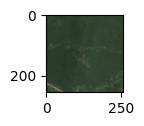

Building 2022/cog/8/142/131.tif
Uploading 30.0 MB to 2022/cog/8/142/131.tif


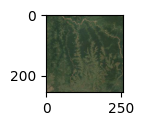

Building 2022/cog/8/142/132.tif
Uploading 28.8 MB to 2022/cog/8/142/132.tif


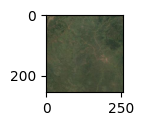

Building 2022/cog/8/142/133.tif
Uploading 22.6 MB to 2022/cog/8/142/133.tif


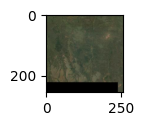

Building 2022/cog/8/143/124.tif
Uploading 14.0 MB to 2022/cog/8/143/124.tif


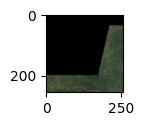

Building 2022/cog/8/143/125.tif
Uploading 27.7 MB to 2022/cog/8/143/125.tif


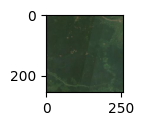

Building 2022/cog/8/143/126.tif
Uploading 27.5 MB to 2022/cog/8/143/126.tif


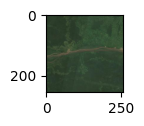

Building 2022/cog/8/143/127.tif
Uploading 22.5 MB to 2022/cog/8/143/127.tif


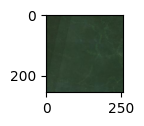

Building 2022/cog/8/143/128.tif
Uploading 24.6 MB to 2022/cog/8/143/128.tif


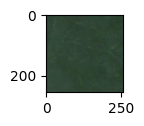

Building 2022/cog/8/143/129.tif
Uploading 24.4 MB to 2022/cog/8/143/129.tif


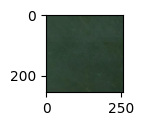

Building 2022/cog/8/143/130.tif
Uploading 26.6 MB to 2022/cog/8/143/130.tif


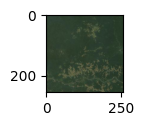

Building 2022/cog/8/143/131.tif
Uploading 32.5 MB to 2022/cog/8/143/131.tif


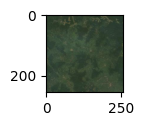

Building 2022/cog/8/143/132.tif
Uploading 36.1 MB to 2022/cog/8/143/132.tif


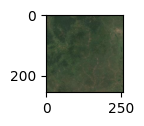

Building 2022/cog/8/143/133.tif
Uploading 30.7 MB to 2022/cog/8/143/133.tif


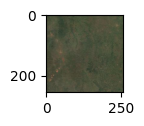

Building 2022/cog/8/143/134.tif
Uploading 26.8 MB to 2022/cog/8/143/134.tif


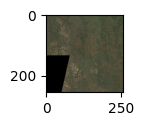

Building 2022/cog/8/143/135.tif
Uploading 18.3 MB to 2022/cog/8/143/135.tif


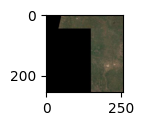

Building 2022/cog/8/143/136.tif
Uploading 8.9 MB to 2022/cog/8/143/136.tif


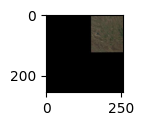

Building 2022/cog/8/144/124.tif
Uploading 26.7 MB to 2022/cog/8/144/124.tif


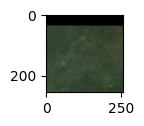

Building 2022/cog/8/144/125.tif
Uploading 27.9 MB to 2022/cog/8/144/125.tif


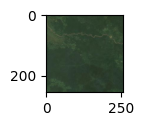

Building 2022/cog/8/144/126.tif
Uploading 27.4 MB to 2022/cog/8/144/126.tif


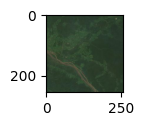

Building 2022/cog/8/144/127.tif
Uploading 25.9 MB to 2022/cog/8/144/127.tif


Building 2022/cog/8/144/128.tif
Uploading 25.5 MB to 2022/cog/8/144/128.tif


Building 2022/cog/8/144/129.tif
Uploading 24.2 MB to 2022/cog/8/144/129.tif


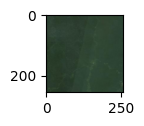

Building 2022/cog/8/144/130.tif
Uploading 29.1 MB to 2022/cog/8/144/130.tif


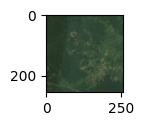

Building 2022/cog/8/144/131.tif


In [ ]:
print(f"Scanning {GCS_BROWSER_BASE_URL}/{BUCKET_NAME}/{SRC_PREFIX}")
src_blobs = storage_client.list_blobs(BUCKET_NAME, prefix=SRC_PREFIX)
src_paths = [b.name for b in src_blobs if b.name.endswith(".tif")]

print(f"Building COGs from {len(src_paths)} GeoTIFFs")
print(src_paths)
print(f"Output: https://console.cloud.google.com/storage/browser/{BUCKET_NAME}/{DEST_PREFIX}")

for subpath in src_paths:
  build_mog(subpath, overwrite=OVERWRITE_EXISTING)

print("Done!")

### Rebuild lo-res overview COG

The world COG is masked based on the hi-res imagery. Force refresh so that it reflects the latest available imagery extends.

In [ ]:
build_mog(f"{SRC_PREFIX}/world-masked.tif", overwrite=True)


## Next steps

To use the imagery generated above in Ground, you currently need to manually add the URL to each Ground survey in should be made available:

1. Open the Ground web console.
2. Select a Survey.
3. Click the gear icon in the top-right corner and click "Edit survey".
4. Click "JSON" in the left side menu.
5. Directly under the top-level "`{`", paste in the snippet generated by running the next cell.

In [ ]:
print('''
  "tileSources": [
    {
      "url": "https://storage.googleapis.com/''' + BUCKET_NAME + '/' + DEST_PREFIX + '''"
    }
  ],
''')